In [1]:
import json
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd

# Retrieve data
Read data as JSON

In [3]:
with open('./data/train.json', 'r') as file:
    data = json.load(file)

# Inspect data

Total numerical information

In [4]:
cuisine = set()
ingredients = set()

for dish in data:
    cuisine.add(dish['cuisine'])
    ingredients.update(dish['ingredients'])

print('Total number of data entries:', len(data))

# print(cuisine)
print('Total number of classes:', len(cuisine))

# print(ingredients)
print('Total number of input parameters:', len(ingredients))

labelsToCode = {}
codeToLabel = {}
for elm in cuisine:
    if elm not in labelsToCode:
        code = len(codeToLabel)
        labelsToCode[elm] = code
        codeToLabel[len(codeToLabel)] = elm

inputsToCode = {}
for elm in ingredients:
    if elm not in inputsToCode:
        inputsToCode[elm] = len(inputsToCode)


Total number of data entries: 39774
Total number of classes: 20
Total number of input parameters: 6714


## Check classes balance

<Axes: xlabel='Cuisine'>

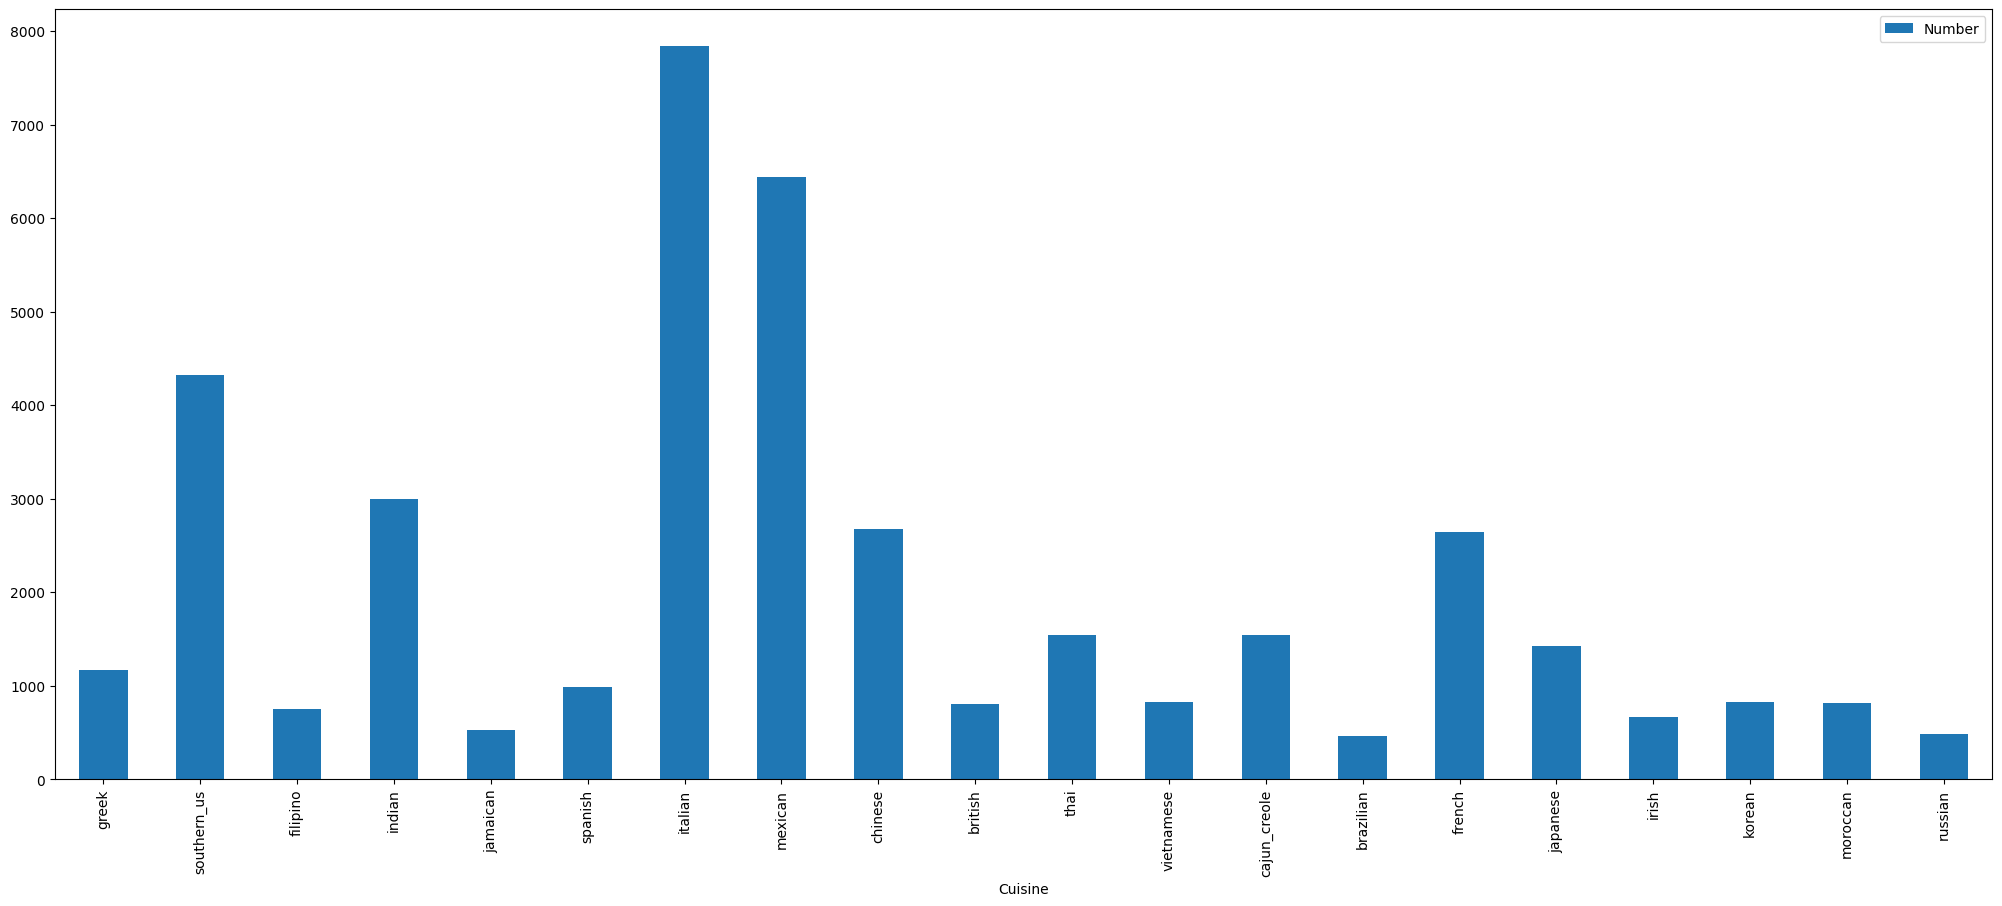

In [5]:
stats = {}
for dish in data:
    label = dish['cuisine']
    if label not in stats:
        stats[label] = 0
    stats[dish['cuisine']] += 1

min = None
for val in stats.values():
    if min is None or val < min:
        min = val

result = pd.DataFrame({'Cuisine': stats.keys(), 'Number': stats.values()})
result.plot(kind = 'bar', x = 'Cuisine', y = 'Number', figsize=(25, 10))

# Transform data

* Map predictors to binary descriptors {0, 1}
* Map labels to {0, 1, ..., 19}

In [6]:
x = []
y = np.array([], dtype=int)

for dish in data:
    descriptors = np.zeros(len(ingredients), dtype=int)
    for elm in dish['ingredients']:
        code = inputsToCode[elm]
        descriptors[code] = 1
    x.append(descriptors)
    y = np.append(y, labelsToCode[dish['cuisine']])

x = np.array(x)

## Split data into train/test sets

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)
print('Number of train entires: ', len(x_train))
print('Number of test entries:', len(x_test))

Number of train entires:  31819
Number of test entries: 7955


In [8]:
x_train_reduced_1, x_train_reduced_2, y_train_reduced_1, y_train_reduced_2 = train_test_split(x_train, y_train, train_size=0.6, test_size=0.2)
print('Number of reduced (1) entires: ', len(x_train_reduced_1))
print('Number of reduced (2) entries:', len(x_train_reduced_2))

Number of reduced (1) entires:  19091
Number of reduced (2) entries: 6364


### Define response visualization function

In [9]:
def printYStats(y):
    stats = {}
    for elm in y:
        label = codeToLabel[elm]
        if label not in stats:
            stats[label] = 0
        stats[label] += 1
    print(stats)
    result = pd.DataFrame({'Class': stats.keys(), 'Number': stats.values()})
    result.plot(kind = 'bar', x = 'Class', y = 'Number', figsize=(25, 10))

## Check train/test sets stratification

              Train  Test
filipino        607   148
vietnamese      684   141
spanish         808   181
chinese        2161   512
french         2122   524
indian         2358   645
italian        6268  1570
mexican        5182  1256
greek           918   257
british         646   158
thai           1243   296
southern_us    3409   911
brazilian       378    89
japanese       1131   292
korean          670   160
moroccan        659   162
irish           520   147
cajun_creole   1224   322
jamaican        434    92
russian         397    92


<Axes: >

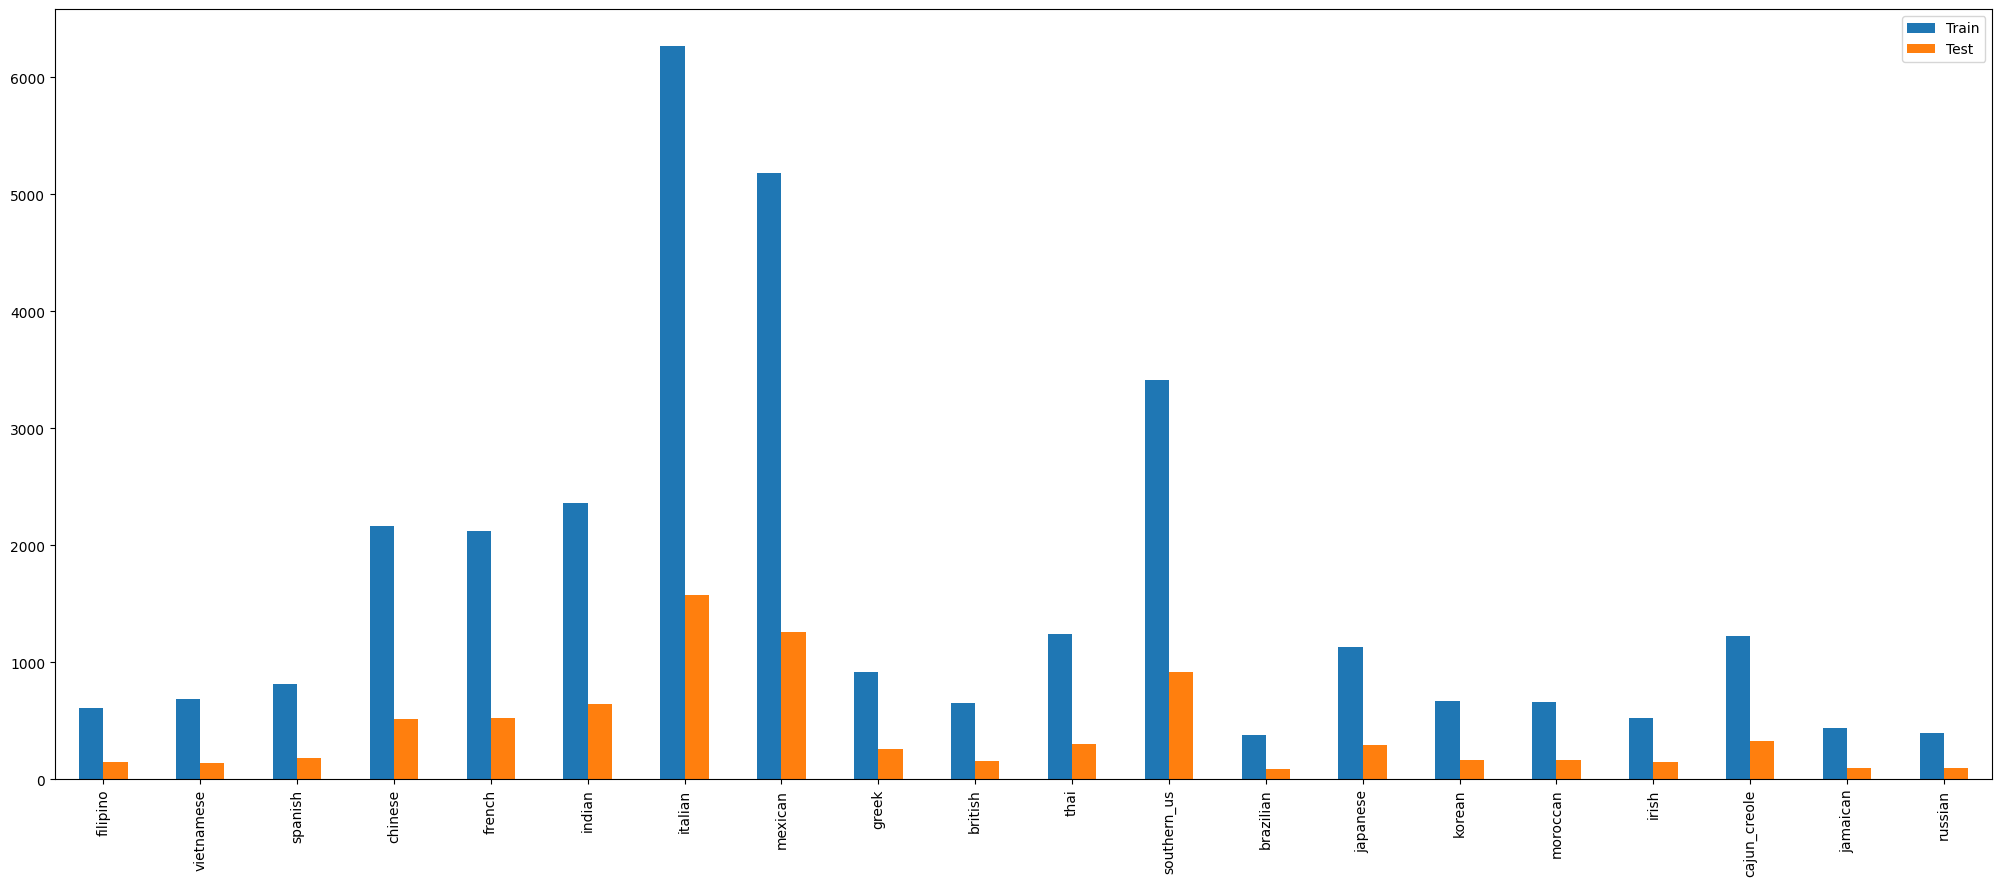

In [10]:
stats = {}
for elm in y_train:
    label = codeToLabel[elm]
    if label not in stats:
        stats[label] = [0, 0]
    stats[label][0] += 1

for elm in y_test:
    label = codeToLabel[elm]
    if label not in stats:
        stats[label] = [0, 0]
    stats[label][1] += 1

result = pd.DataFrame(stats).transpose()
result.rename(columns={0:'Train', 1:'Test'}, inplace=True)
print(result)
result.plot(kind='bar', figsize=(25, 10))

## Fit model to train data

* Use `class_wight='balanced'` for class balancing
* Use different types of models to compare them
* Use different datasets sizes to demonstrate accuracy-training data size dependency

In [16]:
modelLR = LogisticRegression(max_iter=10_000, class_weight='balanced').fit(x_train, y_train)

In [17]:
modelRF = RandomForestClassifier(n_estimators=100, class_weight='balanced').fit(x_train, y_train)

In [18]:
modelLR_r1 = LogisticRegression(max_iter=1000, class_weight='balanced').fit(x_train_reduced_1, y_train_reduced_1)
modelLR_r2 = LogisticRegression(max_iter=1000, class_weight='balanced').fit(x_train_reduced_2, y_train_reduced_2)
modelRF_r1 = RandomForestClassifier(class_weight='balanced').fit(x_train_reduced_1, y_train_reduced_1)
modelRF_r2 = RandomForestClassifier(class_weight='balanced').fit(x_train_reduced_2, y_train_reduced_2)

In [19]:
modelSVC = LinearSVC(class_weight='balanced').fit(x_train, y_train)
modelSVC_r1 = LinearSVC(class_weight='balanced').fit(x_train_reduced_1, y_train_reduced_1)
modelSVC_r2 = LinearSVC(class_weight='balanced').fit(x_train_reduced_2, y_train_reduced_2)

In [20]:
lr_s = modelLR.score(x_test, y_test)
lr_s_r1 = modelLR_r1.score(x_test, y_test)
lr_s_r2 = modelLR_r2.score(x_test, y_test)

rf_s = modelRF.score(x_test, y_test)
rf_s_r1 = modelRF_r1.score(x_test, y_test)
rf_s_r2 = modelRF_r2.score(x_test, y_test)

svc_s = modelSVC.score(x_test, y_test)
svc_s_r1 = modelSVC_r1.score(x_test, y_test)
svc_s_r2 = modelSVC_r2.score(x_test, y_test)

<Axes: title={'center': 'Models Accuracy (on training dataset size)'}>

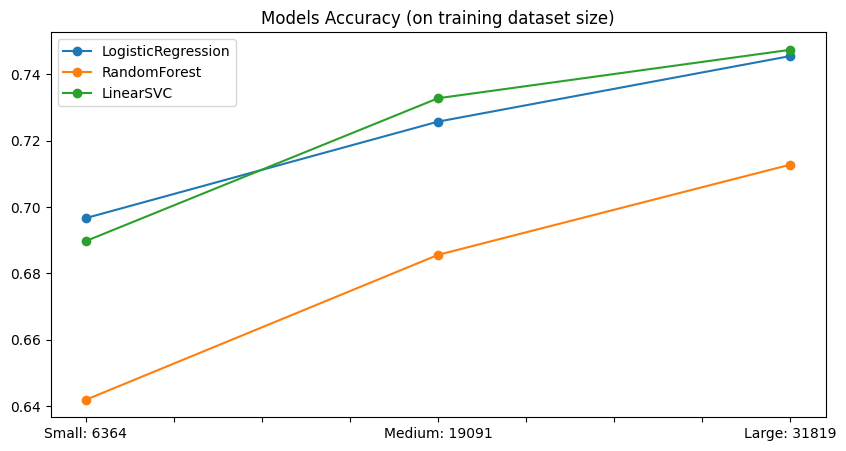

In [21]:
result = pd.DataFrame(
    {
        'LogisticRegression': [lr_s_r2, lr_s_r1, lr_s], 
        'RandomForest': [rf_s_r2, rf_s_r1, rf_s],
        'LinearSVC': [svc_s_r2, svc_s_r1, svc_s]
    }
)
result.rename(
    index={
        0: 'Small: ' + str(len(x_train_reduced_2)), 
        1: 'Medium: ' + str(len(x_train_reduced_1)), 
        2: 'Large: ' + str(len(x_train))
    }, 
    inplace=True
)
result.plot(kind='line', rot=0, figsize=(10, 5), style='o-', title='Models Accuracy (on training dataset size)')



In [22]:
y_predicted = modelSVC.predict(x_test)

In [23]:
print('Classification Report (SVC):\n', classification_report(y_test, y_predicted, target_names=labelsToCode.keys()))

Classification Report (SVC):
               precision    recall  f1-score   support

     italian       0.88      0.79      0.83      1570
     chinese       0.80      0.77      0.78       512
     russian       0.36      0.48      0.41        92
    japanese       0.74      0.72      0.73       292
        thai       0.70      0.67      0.68       296
       greek       0.66      0.76      0.71       257
   brazilian       0.50      0.65      0.57        89
cajun_creole       0.69      0.75      0.72       322
      french       0.61      0.59      0.60       524
  vietnamese       0.48      0.61      0.54       141
    moroccan       0.68      0.77      0.72       162
     mexican       0.92      0.88      0.90      1256
      korean       0.75      0.84      0.79       160
      indian       0.85      0.83      0.84       645
     spanish       0.40      0.54      0.46       181
    jamaican       0.54      0.70      0.61        92
    filipino       0.60      0.72      0.65       1

In [25]:
print('Confusion Matrix (SVC):')
pd.DataFrame(confusion_matrix(y_test, y_predicted)).rename(columns=codeToLabel, index=codeToLabel)

Confusion Matrix (SVC):


,italian,chinese,russian,japanese,thai,greek,brazilian,cajun_creole,french,vietnamese,moroccan,mexican,korean,indian,spanish,jamaican,filipino,southern_us,irish,british
italian,1241,4,17,2,4,47,4,17,68,2,8,23,1,7,51,6,5,34,15,14
chinese,4,392,5,29,19,0,2,4,4,18,0,2,17,2,1,0,6,6,1,0
russian,3,1,44,1,0,1,0,4,10,1,1,0,0,3,2,2,3,4,6,6
japanese,1,19,4,211,5,1,1,0,3,3,1,1,5,27,2,0,3,2,2,1
thai,1,24,0,5,197,0,3,0,0,46,1,6,5,4,0,1,2,1,0,0
greek,17,0,4,0,1,195,1,2,6,0,6,1,0,4,11,0,1,4,2,2
brazilian,4,1,1,0,0,0,58,1,2,0,0,8,0,1,3,2,2,4,0,2
cajun_creole,7,2,3,1,0,3,3,240,11,1,0,4,0,3,1,2,1,38,2,0
french,61,2,13,3,2,15,5,8,311,1,10,4,0,6,20,2,5,22,15,19
vietnamese,1,11,0,2,22,2,1,0,3,86,0,1,2,1,2,0,6,1,0,0
